In [1]:
import os
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from glob import glob
import random

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
high_path = 'drive/My Drive/DenoisingImage/Train/high'
low_path = 'drive/My Drive/DenoisingImage/Train/low'

high_images = sorted(glob(os.path.join(high_path, '*')))
low_images = sorted(glob(os.path.join(low_path, '*')))

# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 8
MAX_TRAIN_IMAGES = 300

In [3]:
# Functions to load and preprocess images
def autocontrast(tensor, cutoff=0):
    tensor = tf.cast(tensor, dtype=tf.float32)
    min_val = tf.reduce_min(tensor)
    max_val = tf.reduce_max(tensor)
    range_val = max_val - min_val
    adjusted_tensor = tf.clip_by_value(tf.cast(tf.round((tensor - min_val - cutoff) * (255 / (range_val - 2 * cutoff))), tf.uint8), 0, 255)
    return adjusted_tensor

def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = autocontrast(image)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image

def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped

def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image

def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


In [4]:
train_low_light_images = low_images[:MAX_TRAIN_IMAGES]
train_enhanced_images = high_images[:MAX_TRAIN_IMAGES]

val_low_light_images = low_images[MAX_TRAIN_IMAGES:]
val_enhanced_images = high_images[MAX_TRAIN_IMAGES:]

train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


In [5]:
# model
def network():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    batch_size = tf.shape(inputs)[0]

    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)

    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)

    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(conv2)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)

    res1 = residual_block(conv3, 128)
    res2 = residual_block(res1, 128)
    res3 = residual_block(res2, 128)
    res4 = residual_block(res3, 128)
    res5 = residual_block(res4, 128)

    deconv1 = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(res5)
    deconv2 = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(deconv1)

    outputs = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(deconv2)
    outputs = tf.keras.layers.add([inputs, outputs])

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
def residual_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.add([inputs, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [7]:
# Perceptual loss model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    layer.trainable = False
outputs = [vgg.get_layer('block3_conv3').output, vgg.get_layer('block4_conv3').output]
model1 = tf.keras.models.Model(inputs=vgg.input, outputs=outputs)


80134624/80134624 [==============================] - 0s 0us/step


In [8]:
def perceptual_loss(y_true, y_pred):
    y_true_features = model1(y_true)
    y_pred_features = model1(y_pred)
    loss = tf.reduce_mean(tf.square(y_true_features[0] - y_pred_features[0])) + tf.reduce_mean(tf.square(y_true_features[1] - y_pred_features[1]))
    return loss

def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def combined_loss(y_true, y_pred):
    return 0.5 * perceptual_loss(y_true, y_pred) + 0.4 * charbonnier_loss(y_true, y_pred)

def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=1.0)

In [9]:
# Build and compile the model
model = network()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss=combined_loss, metrics=[peak_signal_noise_ratio]
)

In [10]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)

Epoch 1/50
37/37 [==============================] - 124s 2s/step - loss: 10.1956 - peak_signal_noise_ratio: 14.1794 - val_loss: 7.4259 - val_peak_signal_noise_ratio: 15.7636
Epoch 2/50
37/37 [==============================] - 68s 2s/step - loss: 7.1944 - peak_signal_noise_ratio: 16.0755 - val_loss: 6.1711 - val_peak_signal_noise_ratio: 16.1186
Epoch 3/50
37/37 [==============================] - 69s 2s/step - loss: 6.3712 - peak_signal_noise_ratio: 16.7789 - val_loss: 5.4464 - val_peak_signal_noise_ratio: 17.4658
Epoch 4/50
37/37 [==============================] - 70s 2s/step - loss: 5.9767 - peak_signal_noise_ratio: 17.0743 - val_loss: 5.4608 - val_peak_signal_noise_ratio: 17.9153
Epoch 5/50
37/37 [==============================] - 60s 2s/step - loss: 5.7756 - peak_signal_noise_ratio: 17.1944 - val_loss: 4.9225 - val_peak_signal_noise_ratio: 17.9984
Epoch 6/50
37/37 [==============================] - 61s 2s/step - loss: 5.4283 - peak_signal_noise_ratio: 17.7629 - val_loss: 5.2066 - val

In [12]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 64)         18496     ['conv2d_1[0][0]']            
                                                                                            

In [13]:
avg_psnr = model.evaluate(val_dataset)[1]
print(f"Average PSNR over validation dataset: {avg_psnr:.2f} dB")

23/23 [==============================] - 12s 486ms/step - loss: 3.8035 - peak_signal_noise_ratio: 20.1023
Average PSNR over validation dataset: 20.1 dB


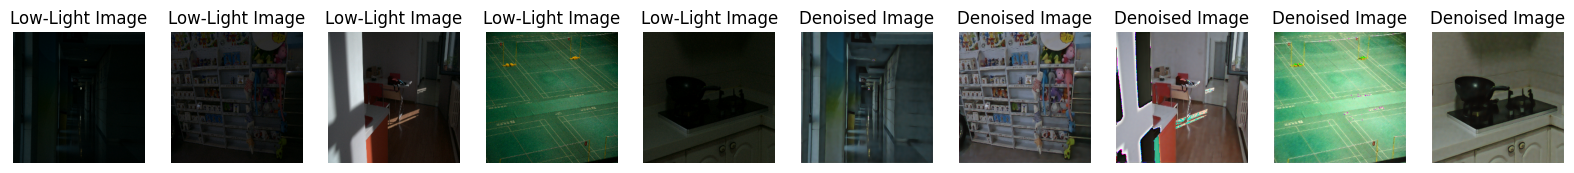

In [46]:
display_images(
    selected_low_light_images_disp + denoised_images_disp,
    ["Low-Light Image"] * 5 + ["Denoised Image"] * 5,
    figsize=(20, 10)
)